<div class="title">Practical Assignment: Support Vector Machines</div>
<div class="subtitle">Métodos Avanzados en Aprendizaje Automático</div>
<div class="author">Carlos María Alaíz Gudín - Universidad Autónoma de Madrid</div>

---

**Initial Configuration**

This cell defines the configuration of Jupyter Notebooks.

In [31]:
%%html
<head><link rel="stylesheet" href="style.css"></head>

In [32]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This cell imports the packages to be used (all of them quite standard except for `Utils`, which is provided with the notebook).

In [52]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from Utils import plot_dataset_clas, plot_svc, plot_svc_animation_frame, init_svc_animation

matplotlib.rc('figure', figsize=(15, 5))
seed = 123

# Introduction

This practical assignment consists in implementing a simplified version of the SVC class of `sklearn`.

This class will contain two fundamentals routines, one for training a non-linear SVC (using the RBF kernel), based on the SMO algorithm for solving the dual optimization problem, and the other one for predicting over new out-of-sample points.

# SMO Algorithm

## Optimization Problem

The dual optimization problem for the Soft-Margin SVM is:
$$
 \left \{ \begin{array}{l} \min_{\boldsymbol{\alpha} \in \mathbb{R}^N} \frac{1}{2} \boldsymbol{\alpha}^\intercal \tilde{\mathbf{K}} \boldsymbol{\alpha} - \boldsymbol{\alpha}^\intercal \mathbf{1} \\ \text{ s.t. } \boldsymbol{\alpha}^\intercal \mathbf{y} = 0 , 0 \le \boldsymbol{\alpha} \le C ,
 \end{array} \right .
$$
where $\tilde{k}_{ij} = y_i y_j \mathcal{K}(\mathbf{x}_i, \mathbf{x}_j)$.

This optimization problem is a QP problem, which is usually solved using an *ad hoc* algorithm: Sequential Minimal Optimization (SMO).

## SMO and Coordinate Descent

The main idea behind SMO is that the optimization problem is too involved to be solved as a whole, but it can be largely simplified considering only a few variables at a time.
In this divide-and-conquer approach, called coordinate descent, the objective function is iteratively minimized over the different variables.

In particular, SMO deals with two variables, the smaller working group that can be modified while respecting the constraints.
Formally, the algorithm updates the current $\alpha^\text{old}_i$ and $\alpha^\text{old}_j$ coefficients to some new values $\alpha_i$ and $\alpha_j$, assuming that $\boldsymbol{\alpha}^\text{old}$ satisfies $(\boldsymbol{\alpha}^\text{old})^\intercal \mathbf{y} = 0$. In order to keep respecting the constraint in the new estimation, the following equation needs to be fulfilled:
\begin{align*}
 & y_i \alpha^\text{old}_i + y_j \alpha^\text{old}_j = y_i \alpha_i + y_j \alpha_j \\
 &\implies y_i (\alpha_i - \alpha^\text{old}_i) = - y_j (\alpha_j - \alpha^\text{old}_j) \\
 &\implies \alpha_i = \alpha^\text{old}_i - y_i y_j (\alpha_j - \alpha^\text{old}_j) .
\end{align*}

For simplicity, one can assume that the update for the $j$-th coefficient is given by $\alpha_j = \alpha^\text{old}_j + d$, and hence the optimization problem becomes a simple one-dimensional minimization.
Therefore, it can be solved by computing the derivative with respect to $d$ and equating to $0$.
After some derivations, the optimum unconstrained update turns out to be:

\begin{align*}
 d &= \frac{y_j (E(\mathbf{x}_j, y_j) - E(\mathbf{x}_i, y_i))}{\kappa} , \text{ where} \\
 \kappa &= 2 \mathcal{K}(\mathbf{x}_i, \mathbf{x}_j) - \mathcal{K}(\mathbf{x}_i, \mathbf{x}_i) - \mathcal{K}(\mathbf{x}_j, \mathbf{x}_j) , \text{ and} \\
 E(\mathbf{x}, y) &= \sum_{i = 1}^N \alpha^\text{old}_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}) - y .
\end{align*}

## Clipping

The previous update does not take into account the box constrains $0 \le \alpha_i, \alpha_j \le C$.
In order to satisfy these constraints for both $\alpha_i$ and $\alpha_j$, $\alpha_j$ has to be clipped to the interval $[L, H]$, where
$$
 \begin{cases}
  L = \max(0, \alpha^\text{old}_j - \alpha^\text{old}_i), & H = \min(C, C - \alpha^\text{old}_i + \alpha^\text{old}_j) & \text{if } y_i \neq y_j , \\
  L = \max(0, \alpha^\text{old}_j + \alpha^\text{old}_i - C), & H = \min(C, \alpha^\text{old}_i + \alpha^\text{old}_j) & \text{if } y_i = y_j .
 \end{cases}
$$

Therefore, the update for $\alpha_j$ becomes:
$$ \alpha_j = \min(\max(\alpha^\text{old}_j + d, L), H) , $$
and, as mentioned above, the corresponding update for $\alpha_i$ is:
$$ \alpha_i = \alpha^\text{old}_i - y_i y_j (\alpha_j - \alpha^\text{old}_j) . $$

## Selecting the Working Pair

There are different methods for selecting the working pair of coefficients $(i, j)$ that will be updated.
Usually, first or second order information is used to choose the working set, trying to find those that will provide the largest minimization of the objective function.

Nevertheless, in this work a simplified version of SMO will be implemented.
The first coefficient $i$ will be selected just iteratively, cycling over all the possible values $i = 1, 2, \dotsc, N$. The second coefficient $j$ is selected randomly over the remaining possible values $j \neq i$.

It should be noted that this approach will not guarantee the convergence in general, since not all possible pairs $(i, j)$ are explored, but it will work in most problems.

## Stopping Criteria

The algorithm will be terminated when a certain maximum number of iteration is reached (for each iteration, all the coefficients are updated), or when after one iteration the total change of the coefficients is smaller than a certain tolerance, $\| \boldsymbol{\alpha} - \boldsymbol{\alpha}^\text{old}\| < \epsilon$.

Since the working pair is generated randomly, it can happen that after a whole iteration the changes are smaller than $\epsilon$ not because the optimization is finished, but because of "bad luck". A workaround is to set $\epsilon = 0$ to force all the iterations.

## Computing the Intercept

Once the optimum dual coefficients $\boldsymbol{\alpha}^*$ have been estimated, the intercept $b^*$ can be computed knowing that any support vector $\mathbf{x}_k$ with $0 < \alpha^*_k < C$ satisfies:
$$ b^* = y_k - \sum_{i = 1}^N \alpha^*_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}_k) . $$

This equality is usually averaged over all the possible vectors $k$ satisfying $0 < \alpha^*_k < C$ for reasons of numerical stability.

## Prediction

Once the model is trained and the optimal parameters $\boldsymbol{\alpha}^*$ and $b^*$ are known, the score predicted over a new sample $\mathbf{x}$ is:
$$ f(\mathbf{x}) = \sum_{i = 1}^N \alpha^*_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}) + b . $$

Finally, the class is assigned with:
$$ \hat{y} = \operatorname{sign}(f(\mathbf{x})) . $$

# Implementation of the SVC

## Requirements

The objective of this assignment is to complete the class `MySVC` sketched below, which should contain at least the following methods.

---
```python
__init__(self, C=1.0, gamma="scale", tol=0.0001, max_iter=10000)
```
* This is the construction method for the class, with the following parameters:
    * `C`: Regularization parameter $C$ of the SVC.
    * `gamma`: Kernel parameter $\gamma$ of the RBF kernel.
    * `tol`: Tolerance for the stopping criterion $\epsilon$.
    * `max_iter`: Maximum number of iterations (in the sense of epochs, each iteration contains a pass through all the coefficients).
* This method should only store the parameters in fields of the class, to be used when needed.

---
```python
fit(self, X, y)
```
* This is the training method, with the following parameters:
    * `X`: Training data matrix $\mathbf{X} \in \mathbb{R}^{N \times d}$.
    * `y`: Vector of labels $\mathbf{y}$, with $y_i \in \{-1, +1\}$.
* This method should solve the dual optimization problem, storing the obtained coefficients and other useful information in fields of the class.

---
```python
decision_function(self, X)
```
* This is the method that computes the output of the SVC, with the following parameters:
    * `X`: Test data matrix $\mathbf{X}' \in \mathbb{R}^{N' \times d}$.
* This method should predict the output (the score) of the SVC, using the information stored in the fields of the class, and return it as a vector

---
```python
predict(self, X)
```
* This is the method that computes the predicted class of the SVC, with the following parameters:
    * `X`: Test data matrix $\mathbf{X}' \in \mathbb{R}^{N' \times d}$.
* This method should predict the assigned class of the SVC, using the information stored in the fields of the class, and return it as a vector.

## Recommendations

Additional auxiliary methods can be defined to simplify the code.
Some suggestions are:

1. A method to compute the output of the SVC, with the current estimated parameters but without considering the intercept:
$$ \sum_{i = 1}^N \alpha_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}) . $$
1. A method to compute $E(\mathbf{x}, y)$.
1. A method to compute the lower and upper bounds $L$ and $H$ for the clipping of the update.
1. A method to estimate $b^*$.

## Implementation

<div class="qst">

* Complete the `MySVC` class below, satisfying the described requirements.

</div>

In [34]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel, linear_kernel
from numpy.linalg import norm

class MySVC():
    """
        SVC with a simplified version of SMO.
    """
    def __init__(self, C=1.0, gamma="scale", tol=0.0001, max_iter=100, kernel='rbf'):
        # Assignment of the hyper-parameters.
        self.C = C
        self.tol = tol
        self.max_iter = max_iter
        self.kernel = kernel
        
        if gamma != 'scale' and gamma != 'auto':
             raise AttributeError('Not valid gamma: {}'.format(self.gamma))
        self.gamma = gamma
        
        # Assign the kernel function
        if self.kernel == 'rbf':
            self.kernel_ = lambda X, Y : rbf_kernel(X, Y)
        elif self.kernel == 'linear':
            self.kernel_ = lambda X, Y: linear_kernel(X, Y)
        elif callable(kernel):
            self.kernel_ = kernel
        else:
            raise AttributeError('Not valid kernel type: {}'.format(self.kernel))
            
    def fit(self, X, y):
        """
            Fits the model to the given data
            - x: attributes
            - y: class labels
        """
        # Constants
        N = X.shape[0]

        # Options for gamma (for compatibility with sklean).
        if (self.gamma == "scale"):
            self.gamma = 1.0 / (N * X.var())
        elif (self.gamma == "auto"):
            self.gamma = 1.0 / N
        else:
            raise ValueError('Not valid gamma: {}'.format(self.gamma))
            
        # Initialization of the dual coefficients (named "a" instead of "alpha" for simplicity).
        self.a = np.zeros(N)

        # Other initializations (complete).
        K = self.kernel_(X, X)

        # Loop over the iterations.
        for it in range(self.max_iter):
            # Initializations.
            a_old = self.a.copy()
            i_indexes = np.arange(N)
            j_indexes = [ np.random.choice(i_indexes[i_indexes != i])
                            for i in i_indexes ]
            
            # Loop over the coefficients.
            for i,j in zip(i_indexes, j_indexes):
                L, H = self._compute_bounds(y, i, j)

                # Update of the corresponding a[i] and a[j] values 
                aj_old = self.a[j].copy()
                self.a[j] = np.minimum(np.maximum(self.a[j] + self._d(X, y, i, j, K), L), H)
                self.a[i] = self.a[i] - y[i]*y[j]*(self.a[j] - aj_old)

            # Check of the stopping conditions.
            if norm(a_old - self.a) < self.tol:
                break

        # Storage of the obtained parameters and computation of the intercept.
        self.support_ = np.where(self.a > 0)[0]
        self.support_vectors_ = X[self.support_]
        self.intercept_ = self._compute_intercept(K, y)
        self.coef_ = None
        self.dual_coef_ = (y * self.a)[self.support_]
        
        # In the linear case we can recover the weights 'w' of the primal solution
        if self.kernel == 'linear':
            self.coef_ = ((self.a * y) @ X).reshape(1, -1) # Reshape for compatibility with Sklearn
        
        return self
    
    def decision_function(self, X):
        """
        
        """
        # Computation of the decision function over X
        return np.dot(self.dual_coef_,
                      self.kernel_(self.support_vectors_, X)) \
                        + self.intercept_

    def predict(self, X):
        """
        
        """
        # Computation of the predicted class over X
        return np.sign(self.decision_function(X))

    # Auxiliary methods.
    def _compute_bounds(self, y, i, j):
        """
            Computes the bounds that alpha[j] must satisfy
            - y: class labels
            - i: i-th position of the dual coefficients
            - j: j-th position of the dual coefficients
        """
        # Clips alpha_j to the [L,H] interval
        if y[i] != y[j]:
            L = np.maximum(0, self.a[j] - self.a[i])
            H = np.minimum(self.C, self.C - self.a[i] + self.a[j])
        else:
            L = np.maximum(0, self.a[j] + self.a[i] - self.C)
            H = np.minimum(self.C, self.a[i] + self.a[j])
        return L,H
        
    def _d(self, X, y, i, j, K):       
        """
        
        """
        # Computes d, the value of the update for the weight alpha_j
        k = 2*K[i,j] - K[i,i] - K[j,j]
        if k == 0:
            raise ValueError('Cannot compute d with k = 0 for (i={},j={})'.format(i,j))
        return y[j] * (self._E(K, y, j) - self._E(K, y, i)) / k
    
    def _E(self, K, y, i):
        """
        
        """
        # Computes E for the expression of d
        return self._compute_output(K, y, self.a, i) - y[i]
        
    def _compute_output(self, K, y, a, i):
        """
            A method to compute the output of the j-th element with the current alpha
            wihtout considering the intercept.
        """
        return np.dot(a * y, K[:, i])
        
    def _compute_intercept(self, K, y):
        """
        
        """
        intercept_indexes = np.where(abs(self.a - self.C/2) < self.C/2)
        return np.mean([ y[i] - self._compute_output(K, y, self.a, i) for i in intercept_indexes ])
    

# Experiments with the SVC

## Comparative with *scikit-learn*

The following cell generates the *moons* dataset, dividing it into train and test splits, and depicting it.

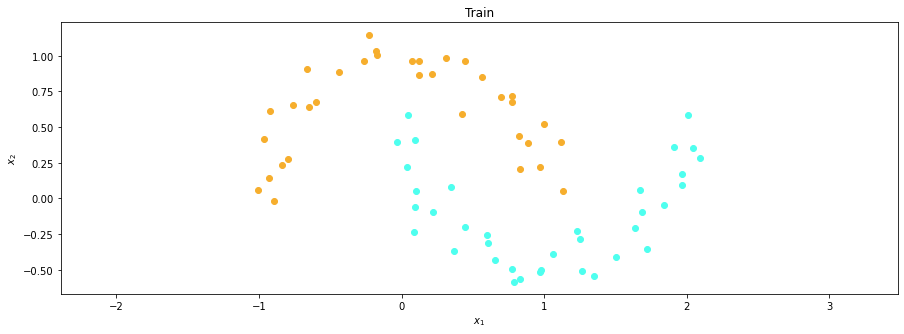

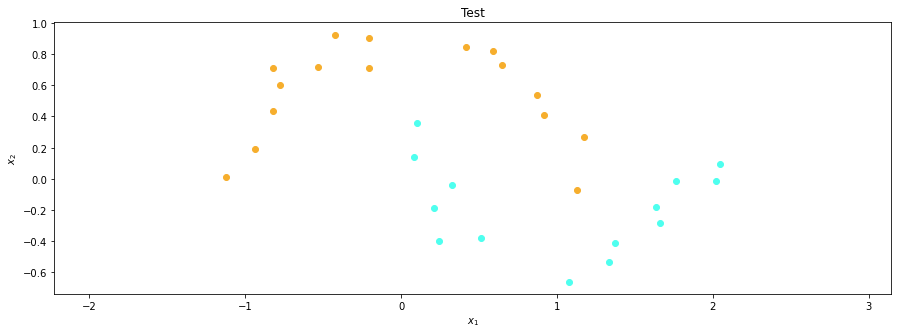

In [35]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

x, y = make_moons(noise=1e-1, random_state=seed)
y[y != 1] = -1

x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.3, random_state=seed)

plot_dataset_clas(x_tr, y_tr)
plt.title('Train'); plt.show()
plot_dataset_clas(x_te, y_te)
plt.title('Test'); plt.show()

<div class="qst">

* Train an SVC model over the training data (`x_tr`, `y_tr`), using both the `SVC` class of `sklearn` and the implemented `MySVC` class.
* Predict using the previous two models over the test data (`x_te`, `y_te`).
* Compare that both classes provide the same outputs (in terms of the decision function and of the predicted class), describing the obtained results. If needed, reduce the default stopping tolerance and/or increase the default maximum number of iterations.

</div>

My SVM's support indexes(21): [ 1  3  8 15 19 20 24 26 27 31 37 39 43 44 50 52 53 55 62 66 69]
Sklearn SVM's support indexes(16): [ 1  8 26 27 37 55 66  2 20 31 43 44 50 52 62 69] 

My SVM accuracy (in test): 0.9666666666666667
Sklearn SVM accuracy (in test): 0.9666666666666667 

My SVM F1-score (in test): 0.9655172413793104
Sklearn SVM F1-score (in test): 0.9655172413793104 

SKlearn's SVM:


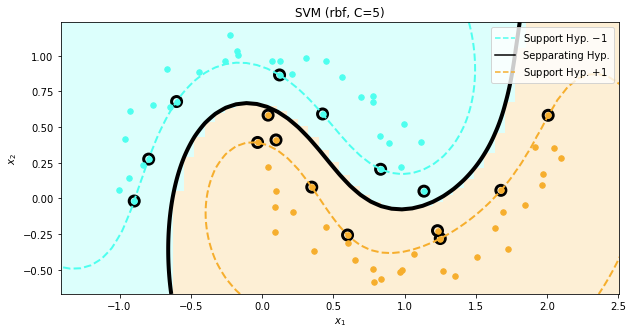

My SVM:


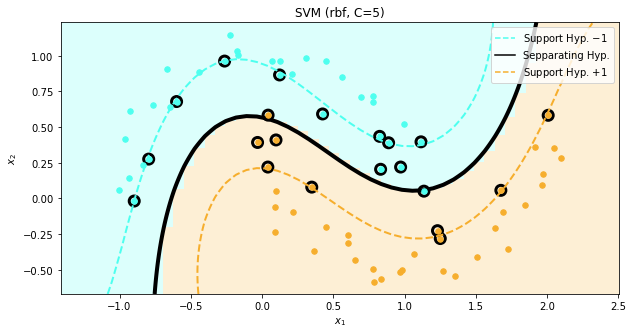

In [81]:
from sklearn.metrics import accuracy_score, f1_score

def compare_svcs(x_tr, y_tr, x_te, y_te, C=1, gamma='scale', kernel='rbf', tol=0.0001, print_all=True):
    # Model definition
    model_my = MySVC(C=C, gamma=gamma, tol=tol, kernel=kernel)
    model_sk = SVC(C=C, gamma=gamma, tol=tol, kernel=kernel)

    # Training of the models.
    model_my.fit(x_tr, y_tr)
    model_sk.fit(x_tr, y_tr)

    # Predictions computations.
    y_predicted_my = model_my.predict(x_te)
    y_predicted_sk = model_sk.predict(x_te)
    
    if print_all:
        # Metrics computations.
        print('My SVM\'s support indexes({}): {}'.format(len(model_my.support_), model_my.support_))
        print('Sklearn SVM\'s support indexes({}): {} \n'.format(len(model_sk.support_), model_sk.support_))

        if kernel == 'linear':
            print('My SVM\'s primal coefficients: {}'.format(model_my.coef_))
            print('Sklearn SVM\'s primal coefficients: {} \n'.format(model_sk.coef_))

        # Comparative of the predicted scores (complete).
        print('My SVM accuracy (in test): {}'.format(accuracy_score(y_te, y_predicted_my)))
        print('Sklearn SVM accuracy (in test): {} \n'.format(accuracy_score(y_te, y_predicted_sk)))
        print('My SVM F1-score (in test): {}'.format(f1_score(y_te, y_predicted_my)))
        print('Sklearn SVM F1-score (in test): {} \n'.format(f1_score(y_te, y_predicted_sk)))

    # Comparative of the predicted classes (complete).
    plot_slack = kernel == 'linear'
    print('SKlearn\'s SVM:')
    plot_svc(x_tr, y_tr, model_sk, plot_slack=plot_slack)
    plt.show()
    print('My SVM:')
    plot_svc(x_tr, y_tr, model_my, plot_slack=plot_slack)
    plt.show()
    
compare_svcs(x_tr, y_tr, x_te, y_te, kernel='rbf', C=1)

TODO: comentar esto y explicar lo que falta de la comparación (no sé qué pide exactamente)

In [119]:
from matplotlib.animation import FuncAnimation
from celluloid import Camera
matplotlib.rc('figure', figsize=(20, 10))

def plot_animation(x_tr, y_tr, Cs=np.arange(1, 41)):
    fig, ax = plt.subplots(2)
    camera = Camera(fig)

    models_my = [
        MySVC(C=C).fit(x_tr, y_tr)
        for C in Cs
    ]
    models_sk = [
        SVC(C=C).fit(x_tr, y_tr)
        for C in Cs
    ]
    
    lims1, lims2 = None, None
    for i in range(len(models_my)):
        lims1 = plot_svc_animation_frame(x_tr, y_tr, ax[0], models_my[i], lims1,
            subtitle='My SVM ({})'.format(models_my[i].kernel))
        lims2 = plot_svc_animation_frame(x_tr, y_tr, ax[1], models_sk[i], lims2,
            subtitle='Sklearn\'s SVM ({})'.format(models_sk[i].kernel))
        ax[0].text(-0.1, 1.5, 'Comparisson with C={}'.format(models_sk[i].C), fontsize=20)
        camera.snap()
        
    animation = camera.animate()
    animation.save('SVC.gif', writer='imagemagick')
    plt.close()
    
plot_animation(x_tr, y_tr)
matplotlib.rc('figure', figsize=(10, 5))

![SVC](SVC.gif)

## Understanding the SVM

<div class="qst">

* Considering the model created with the `MySVC` class:
    * Extract the list of **support vectors**, explaining the followed approach.
    * Extract the list of **training points bad and well classified**, explaining the followed approach.
    * Extract the list of **training points that lie over the supporting hyperplanes**.
    * Extract the list of **training points located on the wrong side of the supporting hyperplanes, but that are well classified**.
* What are the conditions over the dual coefficients $\alpha_i$ that characterize the previous lists (if any)?

</div>

Let us first answer the second question so we can compute such points:

1. The **support vectors** are those points with associated $\alpha_i > 0$.
2. The **correctly and incorrectly classified points** can be computed by using the model to predict the training points `x_tr` and comparing the results to the actual labels `y_tr`.
3. The **points that lie over the supporting hyperplanes** are those points with associated $\alpha_i = 0$.
4. The **points located on the wrong side of the supporting hyperplanes, but that are well classified** are those points correctly classified that have $\alpha_i > 0$.

In the following cells we will display the different required outputs and graph the SVM highlighting the proper points. Let us start by plotting the  **support vectors** surrounded by black circles in the following cell. They were computed by checking which alphas where greater than zero, and saving those indexes (in `model.support_`) to afterwards obtain the support vectors, saved in `model.support_vectors_`. We have kept the same notation that Sklearn uses for this type of model attributes so we plot our's and Sklearn's indistinguishably.

In [ ]:
def show_support_vectors(x_tr, y_tr, x_te, y_te, C=1, gamma='scale', kernel='rbf', tol=0.0001):
    # Model definition and training
    model = MySVC(C=C, gamma=gamma, tol=tol, kernel=kernel)
    model.fit(x_tr, y_tr)
    
    # Show the support vectors
    print('Support vectors: \n{}'.format(model.support_vectors_))
    
    #Plot
    plot_svc(x_tr, y_tr, model)

model = show_support_vectors(x_tr, y_tr, x_te, y_te)

In the following cell we see the **correctly and incorrectly classified training points** surrrounded by green and red circles respectively. These are computed by predicting the labels for the training points and comparing the result with the original labels.

In [ ]:
def highlight_points(points, color):
    plt.scatter(points[:, 0],
                points[:, 1],
                s=100, linewidth=3, facecolors="none", edgecolors=color)

def show_classified_points(x_tr, y_tr, x_te, y_te, C=1, gamma='scale', kernel='rbf', tol=0.0001):
    # Model definition, training and prediction
    model = MySVC(C=C, gamma=gamma, tol=tol, kernel=kernel)
    model.fit(x_tr, y_tr)
    y_predicted = model.predict(x_tr)
    
    # Compute the bad and well classified training points
    hits = np.array([ orig == pred for orig, pred in zip(y_tr, y_predicted)])
    print('Bad classified training points: \n{}'.format(x_tr[~hits]))
    
    # Plot
    plot_svc(x_tr, y_tr, model, plot_support_vectors=False)
    highlight_points(x_tr[hits], '#6F8F72')
    highlight_points(x_tr[~hits], '#F26419')
    
show_classified_points(x_tr, y_tr, x_te, y_te)

In the following cell we display **training points that lie over the supporting hyperplanes** surrounded by a black circle. We may compute these by checking whether the correponding alpha is equal to zero.

In [ ]:
def show_points_overs_supporting_planes(x_tr, y_tr, x_te, y_te, C=1, gamma='scale', kernel='rbf', tol=0.0001):
    # Model definition, training and prediction
    model = MySVC(C=C, gamma=gamma, tol=tol, kernel=kernel)
    model.fit(x_tr, y_tr)
    
    # Compute the bad and well classified training points
    over_indexes = np.array([ i for i, a in enumerate(model.a) if a == 0])
    print('Points over the supporting hyperplanes: \n{}'.format(over_indexes))
    
    # Plot
    plot_svc(x_tr, y_tr, model, plot_support_vectors=False)
    highlight_points(x_tr[over_indexes], 'k')
    
show_points_overs_supporting_planes(x_tr, y_tr, x_te, y_te)

In the following cell we plot **points located on the wrong side of the supporting hyperplanes, but that are well classified** surrounded by a black circles. As it was previously explained, these are points that fullfill two conditions: their alpha is greater than `0` (equivalent to being on the wrong side of the supporting hyperplane, since these are the support vectors), and having a correct prediction.

We may compute these points by intersecting the indexes of the support vectors and the correctly classified points.

In [ ]:
def show_final_points(x_tr, y_tr, x_te, y_te, C=1, gamma='scale', kernel='rbf', tol=0.0001):
    # Model definition, training and prediction
    model = MySVC(C=C, gamma=gamma, tol=tol, kernel=kernel)
    model.fit(x_tr, y_tr)
    y_predicted = model.predict(x_tr)
    
    # Compute the bad and well classified training points
    bad_classified = np.array([ i for i, (orig, pred) in enumerate(zip(y_tr, y_predicted)) if orig == pred])
    result = np.intersect1d(bad_classified, model.support_)
    print('Points : \n{}'.format(result))
    
    # Plot
    plot_svc(x_tr, y_tr, model, plot_support_vectors=False)
    highlight_points(x_tr[result], 'k')
    
show_final_points(x_tr, y_tr, x_te, y_te)

# Extra 1: Linear Kernel

We have implemented our SVM so it supports different type of kernels. In particular, if `kernel=linear`,a  linear kernel is used. In the following cell we find a comparisson between Sklear's linear kernel and our SVM with linear kernel.

In [ ]:
compare_svcs(x_tr, y_tr, x_te, y_te, kernel='linear')

TODO: comentar que aqui también enseñamos los primal coefficients

<!-- Tonto el que lo lea
     Es broma un besito :) -->

# Extra 2: Polynomic kernels

In addition to the linear kernel, our SVM accepts in the `kernel` parameter any function. For instance, we may try polynomial kernels. That is:

$$
K(x,y) = (x^T*y)^d
$$

where `d` is the degree, a given parameter. In the following cells we train train two SVMs with polynomial kernel, with degrees 3 and 4 respectively.

In [ ]:
def plot_polynomic_kernel(x_tr, y_tr, x_te, y_te, degree=3, C=1):
    kernel = lambda X, Y: linear_kernel(X, Y)**degree
    
    model = MySVC(kernel=kernel, C=C)
    model.fit(x_tr, y_tr)
    y_predicted = model.predict(x_te)

    print('My SVM accuracy: {}'.format(accuracy_score(y_te, y_predicted)))
    print('My SVM F1-score: {} \n'.format(f1_score(y_te, y_predicted)))
    plot_svc(x_tr, y_tr, model)
    plt.title('SVM (polynomical, degree={}, C={})'.format(degree, C))
    plt.show()

plot_polynomic_kernel(x_tr, y_tr, x_te, y_te, 3, C=1)
plot_polynomic_kernel(x_tr, y_tr, x_te, y_te, 4, C=1)

# Cosas interesantes a estudiar

- que pasa si al calcular b* no hay ningun elemento (son =0 o =C)
- Porbar distintos metodos de inicializacion de alpha
- Otros tipos de kernel